In [1]:
import random
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import logging
import time
import torch
from transformers import CLIPProcessor, CLIPModel
import os
import os.path as osp
import glob
import json
import re
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import CLIPProcessor, CLIPModel
import torch.optim as optim
from tqdm import tqdm

from torch.utils.data.sampler import Sampler
from collections import defaultdict
import copy
import random
import numpy as np


In [2]:
# Set up logger (or use your existing logger)
logger = logging.getLogger(__name__)
logger.propagate = False
logger.setLevel(logging.INFO)
handler = logging.StreamHandler()
formatter = logging.Formatter('%(asctime)s %(levelname)s: %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)

# Load Model

In [3]:
# Load pre-trained CLIP model and processor
model = CLIPModel.from_pretrained("fine_tuned_clip_model_100")
processor = CLIPProcessor.from_pretrained("fine_tuned_clip_processor_100")

# Move to GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0): CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05, element

# Dataset & Dataloader (ver2.0)

In [4]:

class RandomIdentitySampler(Sampler):
    """
    Randomly sample N identities, then for each identity,
    randomly sample K instances, therefore batch size is N*K.
    Args:
    - data_source (list): list of (input, pid).
    - num_instances (int): number of instances per identity in a batch.
    - batch_size (int): number of examples in a batch.
    """

    def __init__(self, data_source, batch_size=16, num_instances=4):
        self.data_source = data_source
        self.batch_size = batch_size
        self.num_instances = num_instances
        self.num_pids_per_batch = self.batch_size // self.num_instances
        self.index_dic = defaultdict(list) #dict with list value
        #{783: [0, 5, 116, 876, 1554, 2041],...,}
        #for index, (_, pid, _, _) in enumerate(self.data_source):
        for index, (_, pid, _, _, _) in enumerate(self.data_source):
            self.index_dic[pid].append(index)
        self.pids = list(self.index_dic.keys())

        # estimate number of examples in an epoch
        self.length = 0
        for pid in self.pids:
            idxs = self.index_dic[pid]
            num = len(idxs)
            if num < self.num_instances:
                num = self.num_instances
            self.length += num - num % self.num_instances

    def __iter__(self):
        batch_idxs_dict = defaultdict(list)

        for pid in self.pids:
            idxs = copy.deepcopy(self.index_dic[pid])
            if len(idxs) < self.num_instances:
                idxs = np.random.choice(idxs, size=self.num_instances, replace=True)
            random.shuffle(idxs)
            batch_idxs = []
            for idx in idxs:
                batch_idxs.append(idx)
                if len(batch_idxs) == self.num_instances:
                    batch_idxs_dict[pid].append(batch_idxs)
                    batch_idxs = []

        avai_pids = copy.deepcopy(self.pids)
        final_idxs = []

        while len(avai_pids) >= self.num_pids_per_batch:
            selected_pids = random.sample(avai_pids, self.num_pids_per_batch)
            for pid in selected_pids:
                batch_idxs = batch_idxs_dict[pid].pop(0)
                final_idxs.extend(batch_idxs)
                if len(batch_idxs_dict[pid]) == 0:
                    avai_pids.remove(pid)

        return iter(final_idxs)

    def __len__(self):
        return self.length

# ================================
# 1. Dataset
# ================================
class T2IDataset(Dataset):
    """
    dataset: a list of tuples: (img_path, pid, camid, viewid, caption)
    processor: a CLIPProcessor for image & text processing
    """
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        img_path, pid, cid, vid, cap = self.dataset[index]
        img = Image.open(img_path).convert("RGB")

        inputs = self.processor(text=cap, images=img, return_tensors="pt", padding="max_length", truncation=True, max_length=77)
        
        # Remove the batch dimension from each tensor
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        

        return inputs, torch.tensor(pid, dtype=torch.int64), img_path

class CustomCLIPDataset(object):
    dataset_dir = 'VeRi/'

    def __init__(self, root='', verbose=True, **kwargs):
        super(CustomCLIPDataset, self).__init__()
        self.dataset_dir = osp.join(root, self.dataset_dir)
        self.train_dir = osp.join(self.dataset_dir, 'image_train')
        self.gallery_dir = osp.join(self.dataset_dir, 'image_test')
        self.split_path = osp.join(self.dataset_dir, 'reid.json')

        self._check_before_run()

        # Process the splits
        train, query, gallery = self._process_split()

        self.train = train
        self.query = query
        self.gallery = gallery

    def _check_before_run(self):
        """Check if all files are available before going deeper"""
        if not osp.exists(self.dataset_dir):
            raise RuntimeError("'{}' is not available".format(self.dataset_dir))
        if not osp.exists(self.train_dir):
            raise RuntimeError("'{}' is not available".format(self.train_dir))
        if not osp.exists(self.gallery_dir):
            raise RuntimeError("'{}' is not available".format(self.gallery_dir))
        if not osp.exists(self.split_path):
            raise RuntimeError("'{}' is not available".format(self.split_path))

    def _process_split(self):
        with open(self.split_path, 'r') as f:
            data = json.load(f)

        train_set = []
        test_set = []

            # Process each item with a progress bar.
        for item in tqdm(data, desc="Processing split file"):
            img_path = osp.join(self.dataset_dir, item['file_path'])
            pid = item['id']
            split = item['split']
            captions = item['captions'][0]
            camid = int(re.search(r'_c(\d+)', item['file_path']).group(1))
            camid -= 1  # index starts from 0

            if split == 'train':
                train_set.append((img_path, pid, camid, 0, captions))  # viewid is set to 0 for simplicity
            elif split == 'test':
                test_set.append((img_path, pid, camid, 0, captions))

        # Now process test_set into query and gallery sets.
        query_set = []
        gallery_set = []
        pid_to_images = {}

        # Group images by pid with a progress bar.
        for img_path, pid, camid, viewid, captions in tqdm(test_set, desc="Grouping test set by pid"):
            if pid not in pid_to_images:
                pid_to_images[pid] = []
            pid_to_images[pid].append((img_path, camid, viewid, captions))

        # For each pid, assign one image to query and the rest to gallery.
        for pid, images in tqdm(pid_to_images.items(), desc="Splitting test set into query and gallery"):
            query_set.append((images[0][0], pid, images[0][1], images[0][2], images[0][3]))
            for img in images[1:]:
                gallery_set.append((img[0], pid, img[1], img[2], img[3]))

        return train_set, query_set, gallery_set

dataset = CustomCLIPDataset(root="../")
dataset_train = T2IDataset(dataset.train, processor)
dataset_query = T2IDataset(dataset.query, processor)
dataset_gallery = T2IDataset(dataset.gallery, processor)
train_loader = DataLoader(dataset_train, batch_size=64, sampler=RandomIdentitySampler(dataset.train), num_workers=0)
query_loader = DataLoader(dataset_query, batch_size=64, shuffle=False, num_workers=0)
gallery_loader = DataLoader(dataset_gallery, batch_size=64, shuffle=False, num_workers=0)

# Print basic counts for each split
print("Dataset Summary:")
print("Train samples:", len(dataset.train))
print("Query samples:", len(dataset.query))
print("Gallery samples:", len(dataset.gallery))

# Optionally, print the number of unique identities in each split
train_pids = set(pid for _, pid, _, _, _ in dataset.train)
query_pids = set(pid for _, pid, _, _, _ in dataset.query)
gallery_pids = set(pid for _, pid, _, _, _ in dataset.gallery)
print("Unique train identities:", len(train_pids))
print("Unique query identities:", len(query_pids))
print("Unique gallery identities:", len(gallery_pids))

Splitting test set into query and gallery: 100%|██████████| 200/200 [00:00<00:00, 95542.23it/s]

Dataset Summary:
Train samples: 37746
Query samples: 200
Gallery samples: 11379
Unique train identities: 575
Unique query identities: 200
Unique gallery identities: 200


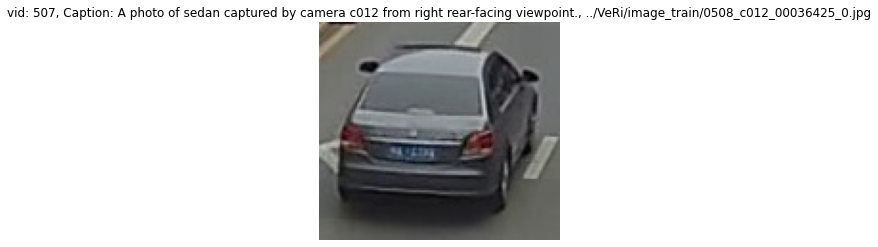

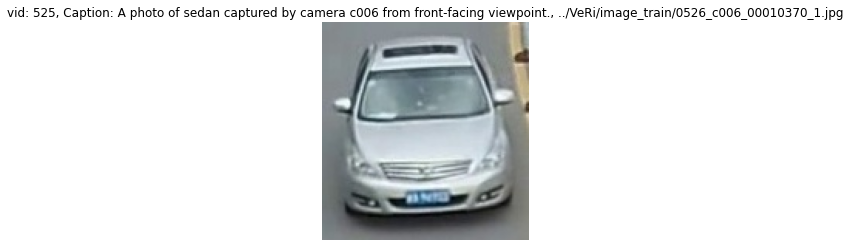

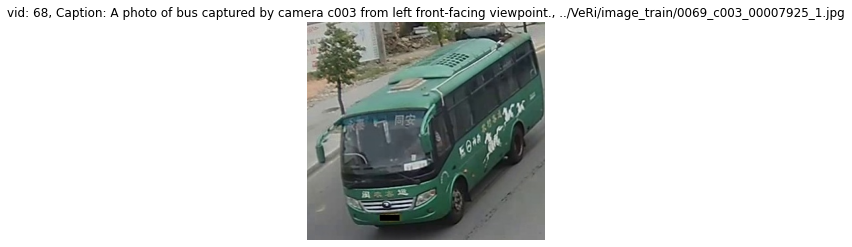

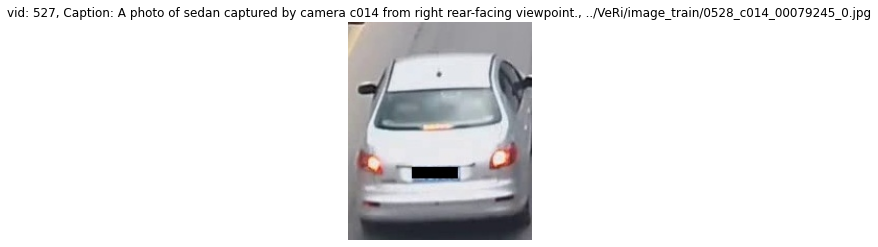

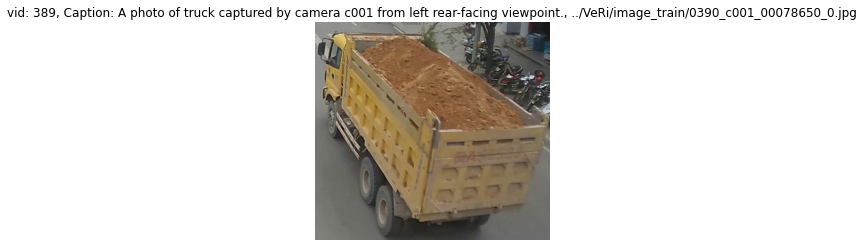

In [5]:
import random
import matplotlib.pyplot as plt
from PIL import Image



# Randomly sample 5 entries from the training set
sample_items = random.sample(dataset.train, 5)

for img_path, pid, camid, viewid, caption in sample_items:
    img = Image.open(img_path).convert("RGB")
    plt.figure()
    plt.imshow(img)
    plt.title(f"vid: {pid}, Caption: {caption}, {img_path}")
    plt.axis('off')
    plt.show()

# Loss function

In [5]:
import torch.nn.functional as F

def clip_loss(image_features, text_features, temperature=0.07):
    """
    Compute CLIP contrastive loss for image and text features.

    :param image_features: Image embeddings (batch_size, embedding_dim)
    :param text_features: Text embeddings (batch_size, embedding_dim)
    :param temperature: Scaling factor
    :return: Contrastive loss
    """
    # Normalize embeddings
    image_features = F.normalize(image_features, p=2, dim=-1)
    text_features = F.normalize(text_features, p=2, dim=-1)

    # Compute similarity matrix (batch_size x batch_size)
    logits = (image_features @ text_features.T) / temperature

    # Ground truth labels (each image matches only its corresponding text)
    batch_size = image_features.shape[0]
    labels = torch.arange(batch_size, dtype=torch.long, device=image_features.device)

    # Compute loss
    loss = (F.cross_entropy(logits, labels) + F.cross_entropy(logits.T, labels)) / 2
    return loss

# ================================
# 2. Define Batch-Hard Triplet Loss
# ================================
def batch_hard_triplet_loss(embeddings, labels, margin=0.3):
    """
    Computes the batch-hard triplet loss.
    
    embeddings: Tensor of shape (batch_size, embedding_dim)
    labels: Tensor of shape (batch_size)
    margin: Triplet loss margin
    """
    # Compute pairwise Euclidean distances
    pairwise_dist = torch.cdist(embeddings, embeddings, p=2)  # shape: (batch_size, batch_size)
    
    loss = torch.tensor(0.0, device=embeddings.device)
    batch_size = embeddings.size(0)
    for i in range(batch_size):
        # Positive samples (same label) but not the anchor itself
        pos_mask = (labels == labels[i]) & (torch.arange(batch_size, device=labels.device) != i)
        # Negative samples (different label)
        neg_mask = labels != labels[i]
        if pos_mask.sum() == 0 or neg_mask.sum() == 0:
            continue
        hardest_positive = pairwise_dist[i][pos_mask].max()
        hardest_negative = pairwise_dist[i][neg_mask].min()
        loss += F.relu(hardest_positive - hardest_negative + margin)
    return loss / batch_size

# Utils

In [6]:
# AverageMeter for tracking metrics
class AverageMeter:
    def __init__(self):
        self.reset()
    def reset(self):
        self.sum = 0.0
        self.count = 0
    def update(self, val, n=1):
        self.sum += val * n
        self.count += n
    @property
    def avg(self):
        return self.sum / self.count if self.count > 0 else 0.0

# Train

In [23]:
import torch.optim as optim

loss_meter = AverageMeter()
acc_meter = AverageMeter()

log_period = 10  # log every 10 iterations
start_time = time.time()

# Define optimizer
optimizer = optim.AdamW(model.parameters(), lr=5e-6, weight_decay=0.01)

# Training loop
num_epochs = 90
for epoch in range(num_epochs):
    model.train()
    loss_meter.reset()
    acc_meter.reset()

    for n_iter, (inputs, labels, _) in enumerate(train_loader):
        # batch is a tuple: (inputs, label)
        labels = labels.to(device)
        inputs = {key: value.to(device) for key, value in inputs.items()}

        optimizer.zero_grad()

        text_features = model.get_text_features(inputs['input_ids'])
        image_features = model.get_image_features(inputs['pixel_values'])

        embeddings = (text_features + image_features) / 2  # shape: (batch_embedding_dim)
      
        loss = batch_hard_triplet_loss(embeddings, labels, margin=0.3)
        # print(loss) 
        loss.backward()
        optimizer.step()

        logits = image_features @ text_features.T
        batch_acc = (logits.argmax(dim=1) == labels).float().mean()

        # Update meters (use the batch size; here assuming inputs['pixel_values'].size(0) is batch size)
        batch_size = inputs['pixel_values'].size(0)
        loss_meter.update(loss.item(), n=batch_size)
        acc_meter.update(batch_acc.item(), n=batch_size)

        # Ensure all CUDA operations are finished
        torch.cuda.synchronize()
        
        if (n_iter + 1) % log_period == 0:
            logger.info(
                "Epoch[{}] Iteration[{}/{}] Loss: {:.3f}, Acc: {:.3f}"
                .format(
                    epoch,
                    (n_iter + 1),
                    len(train_loader),
                    loss_meter.avg,
                    acc_meter.avg
                )
            )
    end_time = time.time()
    time_per_batch = (end_time - start_time) / (n_iter + 1)
    logger.info("Epoch {} done. Time per batch: {:.3f}[s] Speed: {:.1f}[samples/s]"
                .format(epoch, time_per_batch, train_loader.batch_size / time_per_batch))
    
    if epoch % 9 == 0:
        # Save fine-tuned model
        model.save_pretrained("fine_tuned_clip_model_{}".format(epoch))
        processor.save_pretrained("fine_tuned_clip_processor_{}".format(epoch))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
2025-03-26 22:28:29,960 INFO: Epoch[0] Iteration[10/578] Loss: 0.630, Acc: 0.000
2025-03-26 22:28:48,212 INFO: Epoch[0] Iteration[20/578] Loss: 0.494, Acc: 0.000
2025-03-26 22:29:05,286 INFO: Epoch[0] Iteration[30/578] Loss: 0.429, Acc: 0.002
2025-03-26 22:29:23,315 INFO: Epoch[0] Iteration[40/578] Loss: 0.395, Acc: 0.003
2025-03-26 22:29:40,416 INFO

KeyboardInterrupt: 

# Evaluation

In [6]:
# ----- Assume these variables are already available -----
# query_embeddings: Tensor of shape (num_query, d)
# query_labels: Tensor of shape (num_query,)
# query_img_paths: List of file paths for query images
# gallery_embeddings: Tensor of shape (num_gallery, d)
# gallery_labels: Tensor of shape (num_gallery,)
# gallery_img_paths: List of file paths for gallery images
# ---------------------------------------------------------

def display_inference_sampels(query_embeddings, query_labels, query_img_paths, 
                          gallery_embeddings, gallery_labels, gallery_img_paths):
    
    query_img_paths = np.concatenate(query_img_paths).tolist()
    gallery_img_paths = np.concatenate(gallery_img_paths).tolist()
    similarity_matrix = torch.matmul(query_embeddings, gallery_embeddings.T)  # Shape: (num_query, num_gallery)
    similarity_matrix = similarity_matrix.cpu().numpy()
    
    # Randomly select 5 query indices
    num_queries = query_embeddings.shape[0]
    selected_query_indices = random.sample(range(num_queries), 5)

    # Set up the plot: 5 rows (one per query) and 6 columns (1 query + 5 top matches)
    fig, axes = plt.subplots(5, 6, figsize=(18, 15))

    for row, q_idx in enumerate(selected_query_indices):
        # Load and display the query image
        query_img = plt.imread(query_img_paths[q_idx])
        # Get query label
        query_label = query_labels[q_idx].item()
        axes[row, 0].imshow(query_img)
        axes[row, 0].axis('off')
        axes[row, 0].set_title("Query "+ str(query_label))

        # Retrieve the top-5 gallery indices for this query based on similarity scores
        # (Here, we simply use the highest similarity scores; ensure that query and gallery are disjoint if needed.)
        top5_gallery_indices = np.argsort(-similarity_matrix[q_idx])[:5]

        # Loop over the top-5 retrieved gallery images
        for col, g_idx in enumerate(top5_gallery_indices, start=1):
            gallery_img = plt.imread(gallery_img_paths[g_idx])
            axes[row, col].imshow(gallery_img)
            axes[row, col].axis('off')

            # Get similarity score
            score = similarity_matrix[q_idx][g_idx]

            # Determine if the retrieved image is a correct match
            gallery_label = gallery_labels[g_idx].item()
            if gallery_label == query_label:
                box_color = 'green'
                title_text = f"Correct ({score:.2f}), ID ({str(gallery_label)})"
            else:
                box_color = 'red'
                title_text = f"Wrong ({score:.2f}, ID ({str(gallery_label)})"

            # Add a colored border to the image: a rectangle covering the image
            rect = patches.Rectangle((0, 0), gallery_img.shape[1], gallery_img.shape[0],
                                     linewidth=5, edgecolor=box_color, facecolor='none')
            axes[row, col].add_patch(rect)
            axes[row, col].set_title(title_text, color=box_color, fontsize=10)

    plt.tight_layout()
    plt.show()
    
def evaluate_reid(query_features, query_labels, gallery_features, gallery_labels):
    """
    Computes CMC and mAP for a re-identification system.
    
    Parameters:
        query_features (torch.Tensor): Query embeddings of shape (num_query, d)
        query_labels (torch.Tensor): Query labels of shape (num_query,)
        gallery_features (torch.Tensor): Gallery embeddings of shape (num_gallery, d)
        gallery_labels (torch.Tensor): Gallery labels of shape (num_gallery,)
    
    Returns:
        cmc (np.array): CMC curve (e.g., Rank-1, Rank-5, Rank-10 accuracy)
        mAP (float): Mean average precision over all queries
    """
    # Convert to numpy arrays for easier processing
    query_features = query_features.cpu().numpy()
    query_labels = query_labels.cpu().numpy()
    gallery_features = gallery_features.cpu().numpy()
    gallery_labels = gallery_labels.cpu().numpy()
    
    num_query = query_features.shape[0]
    num_gallery = gallery_features.shape[0]
    
    # Compute Euclidean distances (or use cosine similarity, here we use Euclidean)
    # For cosine similarity, you could use: dist_matrix = 1 - np.dot(query_features, gallery_features.T)
    #dist_matrix = np.linalg.norm(query_features[:, np.newaxis] - gallery_features, axis=2)
    dist_matrix = 1 - np.dot(query_features, gallery_features.T)
    
    # Initialize CMC and list to store AP for each query
    CMC = np.zeros(num_gallery)
    APs = []
    
    for i in range(num_query):
        # Get sorted indices for gallery samples for query i (ascending distances)
        sorted_indices = np.argsort(dist_matrix[i])
        # Create a binary array indicating correct matches (1 for match, 0 otherwise)
        matches = (gallery_labels[sorted_indices] == query_labels[i]).astype(np.int32)
        
        if matches.sum() == 0:
            # Skip queries that have no matches in the gallery (should rarely happen if gallery is complete)
            continue
        
        # CMC: For Rank-1, Rank-5, etc.
        # Find the first correct match index
        first_match_index = np.where(matches == 1)[0][0]
        CMC[first_match_index:] += 1
        
        # Compute average precision (AP) for the query
        # The precision at each rank where a correct match is found
        tmp_cmc = matches.cumsum()
        precision_at_k = tmp_cmc / (np.arange(len(matches)) + 1)
        AP = (precision_at_k * matches).sum() / matches.sum()
        APs.append(AP)
    
    # Average over all queries
    cmc = CMC / num_query
    mAP = np.mean(APs)
    
    return cmc, mAP

# ---------------------------
# Example usage:
# Assuming you have query and gallery embeddings and labels:
# query_features: Tensor of shape (num_query, d)
# query_labels: Tensor of shape (num_query,)
# gallery_features: Tensor of shape (num_gallery, d)
# gallery_labels: Tensor of shape (num_gallery, d)

# For example, if using your evaluation dataloader to compute embeddings:
def extract_embeddings(model, dataloader, device):
    model.eval()
    all_embeddings = []
    all_labels = []
    all_img_paths = []
    with torch.no_grad():
        # for batch in dataloader:
            #inputs, labels, img_paths = batch
        for batch_idx, (inputs, labels, img_paths) in enumerate(tqdm(dataloader, desc="Loading Data")):
            labels = labels.to(device)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            # Here, we assume you combine modalities; adjust if needed.
            text_features = model.get_text_features(inputs['input_ids'])
            image_features = model.get_image_features(inputs['pixel_values'])
            embeddings = (text_features + image_features) / 2
            embeddings = torch.nn.functional.normalize(embeddings, p=2, dim=-1)
            all_embeddings.append(embeddings)
            all_labels.append(labels)
            all_img_paths.append(img_paths)
    all_embeddings = torch.cat(all_embeddings, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    return all_embeddings, all_labels, all_img_paths

# Compute embeddings for query and gallery sets separately
# (For simplicity, here we assume the dataloader provides a single set; in practice, use separate query/gallery loaders)
query_embeddings, query_labels, query_img_paths = extract_embeddings(model, query_loader, device)
gallery_embeddings, gallery_labels, gallery_img_paths = extract_embeddings(model, gallery_loader, device)

cmc, mAP = evaluate_reid(query_embeddings, query_labels, gallery_embeddings, gallery_labels)
print("Rank-1 Accuracy: {:.4f}".format(cmc[0]))
print("Rank-5 Accuracy: {:.4f}".format(cmc[4] if len(cmc) >= 5 else 0))
print("Rank-10 Accuracy: {:.4f}".format(cmc[9] if len(cmc) >= 10 else 0))
print("mAP: {:.4f}".format(mAP))

# display_inference_sampels(query_embeddings, query_labels, query_img_paths, 
#                           gallery_embeddings, gallery_labels, gallery_img_paths)



Loading Data: 100%|██████████| 178/178 [02:47<00:00,  1.06it/s]


query_features
query_labels
gallery_features
gallery_labels
dist_matrix
Rank-1 Accuracy: 0.9600
Rank-5 Accuracy: 0.9800
Rank-10 Accuracy: 0.9800
mAP: 0.6354


# Visualise

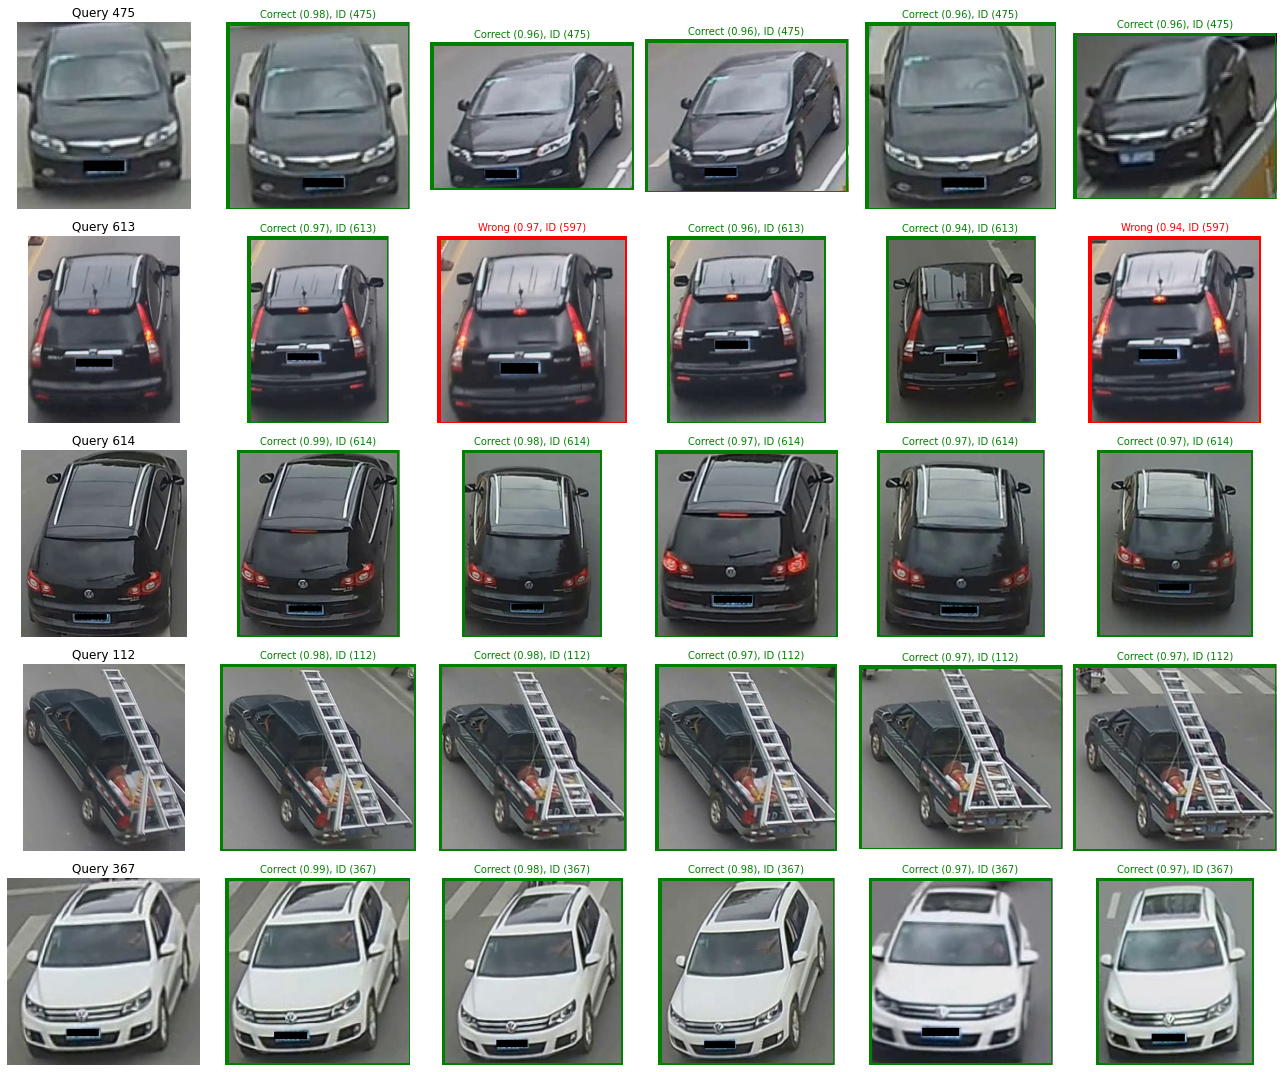

In [7]:
display_inference_sampels(query_embeddings, query_labels, query_img_paths, 
                          gallery_embeddings, gallery_labels, gallery_img_paths)


In [ ]:
gallery_loader